In [1]:
from torch.utils.flop_counter import suffixes

from src import params
from src.data_preprocess import utils
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ast


In [2]:
weight_control = False
disease_columns = ['diseases_within_window_phecode_selected', 'chapter_within_window_phecode_selected']
(params.final_data_path/ 'UKB_wave_0_diseases_first_occurrence_and_cancer.pkl')



In [5]:
# combine two datasets and check the disease distribution
disease_column = 'diseases_within_window_phecode_selected'
disease_count_column = 'disease_count_within_window_selected'

df_fo = pd.read_csv(params.final_data_path.parents[3]/ 'Data/final_data/UKB_wave_0_diseases_first_occurrence.csv')
df_fo[disease_column] = [ast.literal_eval(x) if str(x) not in params.nan_str else None for x in df_fo[disease_column]]

df_disease = pd.read_pickle(f'{str(params.intermediate_path).replace("src/data_preprocess/","")}/cancer_registry_data_refined.pkl')
df_disease = df_disease.merge(df_fo[['eid', disease_column]], how='left', left_on='eid', right_on='eid', suffixes=('_cancer', '_fo'))

df_disease[disease_column] = [
    list(set((x if str(x) not in params.nan_str else []) + (y if str(y) not in params.nan_str else [])))
    for x, y in zip(df_disease[disease_column + '_cancer'], df_disease[disease_column + '_fo'])]
df_phe_db = pd.read_csv('/Users/valler/Python/OX_Thesis/Chapter_2_Disease_Clustering/Data/downloaded_data/ICD_10/phecode_definitions1.2.csv')
df_disease[disease_columns[1]]=[[df_phe_db.loc[df_phe_db['phecode']==disease,'category_number'].values[0] for disease in x] if str(x) not in params.nan_str else None for x in df_disease[disease_column]]

level = 'fo+cancer'


In [4]:
# only check one of the datasets
# df_disease = pd.read_csv(params.final_data_path.parents[3]/ 'Data/final_data/UKB_wave_0_diseases_first_occurrence.csv')
df_disease = pd.read_pickle(f'{str(params.intermediate_path).replace("src/data_preprocess/","")}/cancer_registry_data_refined.pkl')
cancer_control = True

In [6]:
disease_column = 'chapter_within_window_phecode_selected'
disease_count_column = 'disease_count_within_window_selected'
df = pd.read_pickle(f'{str(params.final_data_path).replace("src/data_preprocess/","")}/UKB_wave_0_final_non_standardised.pkl')
if not cancer_control:
    df_disease[disease_column] = [ast.literal_eval(x) if str(x) not in params.nan_str else None for x in df_disease[disease_column]]
df = df.merge(df_disease[['eid', disease_column]], how='left', left_on='eid', right_on='eid')
df[disease_count_column] = [len(x) if str(x) not in params.nan_str else 0 for x in df[disease_column]]

In [7]:
temp = {'infectious diseases': 1,  'neoplasms': 2, 'endocrine/metabolic': 3, 'hematopoietic': 4, 'mental disorders': 5, 'neurological': 6, 'sense organs': 7, 'circulatory system': 8, 'respiratory': 9, 'digestive': 10, 'genitourinary': 11, 'pregnancy complications': 12, 'dermatologic': 13, 'musculoskeletal': 14, 'congenital anomalies': 15, 'symptoms': 17, 'injuries & poisonings': 18}
phe_cate_dict = {y:x for x,y in temp.items()}

# plots

## average disease counts

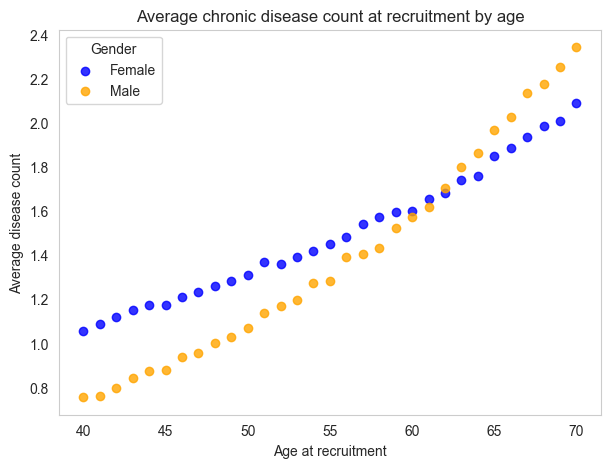

<Figure size 700x500 with 0 Axes>

In [15]:
df_to_plot = df[[disease_column,disease_count_column, '31', '21022']].copy()
# 31: gender
# 21022: age at recruitment
# display the disease count by gender and age
df_to_plot = df_to_plot.groupby(['31', '21022']).agg(cases_count=(disease_count_column, 'count'), disease_count=(disease_count_column, 'mean')).reset_index()
# set 31 as categorical variable
df_to_plot['31'] = df_to_plot['31'].astype('category')
df_to_plot['31'] = df_to_plot['31'].cat.rename_categories(['Female', 'Male'])
df_to_plot = df_to_plot.loc[(df_to_plot['21022']>=40) & (df_to_plot['21022']<=70),] # delete 40 and 70 as they are severe underpresented


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [7,5]
# Colors to use for the two categories (adjust as needed)
colors = ['blue', 'orange']
# Plot each category with its own color and label
for i, category in enumerate(df_to_plot['31'].cat.categories):
    df_subset = df_to_plot[df_to_plot['31'] == category]
    ax.scatter(df_subset['21022'], df_subset['disease_count'], color=colors[i], label=category,alpha=0.8)

ax.grid(False)
# Add a legend
ax.legend(title='Gender')
plt.title(f'Average chronic disease count at recruitment by age')
plt.xlabel('Age at recruitment')
plt.ylabel('Average disease count')
plt.show()
#plt.savefig(params.current_path/f'plot/{level}/average_disease_count_at_recruitment_{record_column}_{"weighted" if weight_control else ""}.pdf')
#plt.savefig(params.current_path.parents[1]/f'plot/{level}/average_disease_count_at_recruitment_{"weighted" if weight_control else ""}.pdf')


## disease chapter count by age and gender 

In [16]:
# mark the chapter of the diseases
disease_column 
def count_chapter(row):
    """
    count the chapter of the diseases for each row in the dataframe
    """
    if str(row[disease_column]) not in ['None','nan','NaN']:
        chapters = [str(x) for x in row[disease_column]]
        count_dict = Counter(chapters)
        if 'weight' in row.index.tolist():
            count_dict = {k: v*row['weight'] for k, v in count_dict.items()}
    else:
        count_dict = None
    return count_dict

if weight_control:
    df_to_plot = df[[disease_column, '31', '21022','weight']].copy()
else:
    df_to_plot = df[[disease_column, '31', '21022']].copy()

# separate diseases by the chapter name (each chapter will have a separate column)
df_to_plot['chapter_count'] = df_to_plot.apply(count_chapter, axis=1)

chapter_ranges = df[df[disease_column].notnull()][disease_column].apply(lambda x: [int(y) for y in x]).explode().dropna().unique()
chapter_ranges.sort()
for column in chapter_ranges:
    df_to_plot[f'chapter_{column}'] = [x[str(column)] if isinstance(x, dict) and str(column) in x.keys() else None for x in df_to_plot['chapter_count']]


df_plot_2 = df_to_plot.pivot_table(index=['21022', '31'],  values=[f'chapter_{x}' for x in chapter_ranges], aggfunc='sum').reset_index()
# remove sparse data points that have age below 40 or over 70 (same as the last plot)
df_plot_2.drop(df_plot_2.loc[(df_plot_2['21022'] < 40) | (df_plot_2['21022'] > 70)].index, inplace=True)

# set 31 as categorical variable
df_plot_2['31'] = df_plot_2['31'].astype('category')
df_plot_2['31'] = df_plot_2['31'].cat.rename_categories(['Female', 'Male'])


### abs count

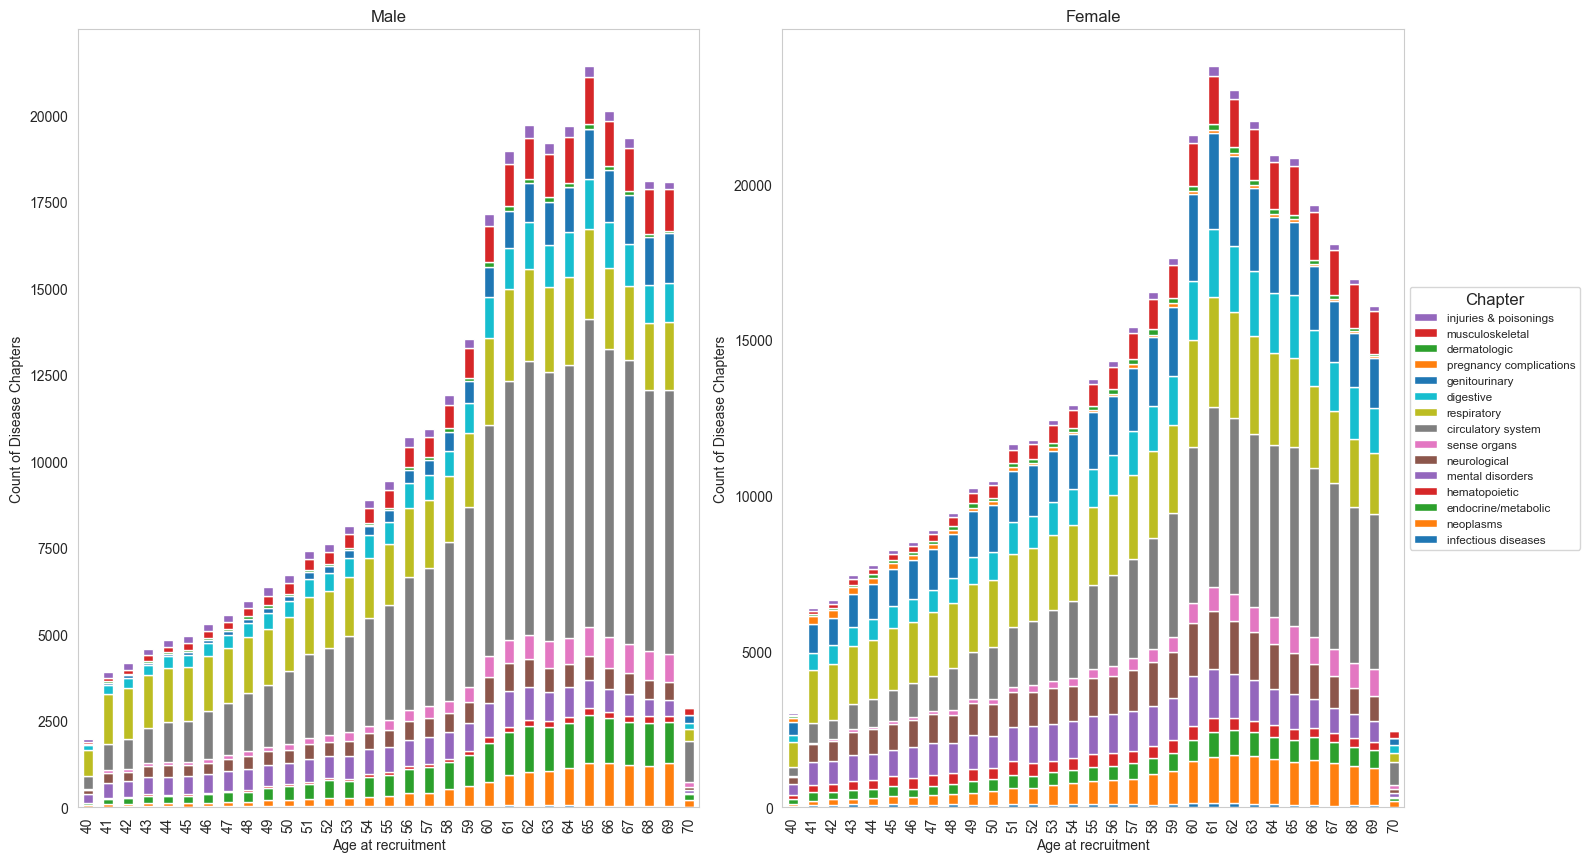

In [18]:


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [16,9]
# Create a subset of the dataframe with only the columns to be plotted
gender = 'Male'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)
# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title(gender)
ax1.set_xlabel('Age at recruitment')
ax1.set_ylabel('Count of Disease Chapters')
# remove the legend
ax1.get_legend().remove()

gender = 'Female'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)

# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True,  ax=ax2)
ax2.set_title(gender)
ax2.set_xlabel('Age at recruitment')
ax2.set_ylabel('Count of Disease Chapters')


handles, labels = ax2.get_legend_handles_labels()  # reverse the order of legend
labels = [phe_cate_dict[int(str(x).replace('chapter_',''))] for x in labels]

ax2.legend(reversed(handles), reversed(labels), title='Chapter', title_fontsize='large', fontsize='small', loc='center left', bbox_to_anchor=(1.0, 0.5))

for ax in [ax1, ax2]:
    ax.grid(False)
# fig.suptitle('Diseases chapter count by age and gender')
fig.tight_layout(rect=[0, 0.01, 1, 0.98])
# plt.show()

# plt.savefig(params.current_path/f'plot/{level}/diseases_chapter_count_{record_column}_by_age_and_gender{"_weighted" if weight_control else ""}.pdf')
plt.savefig(params.current_path.parents[1]/f'plot/{level}/diseases_chapter_count_by_age_and_gender{"_weighted" if weight_control else ""}.pdf')


### proportional view

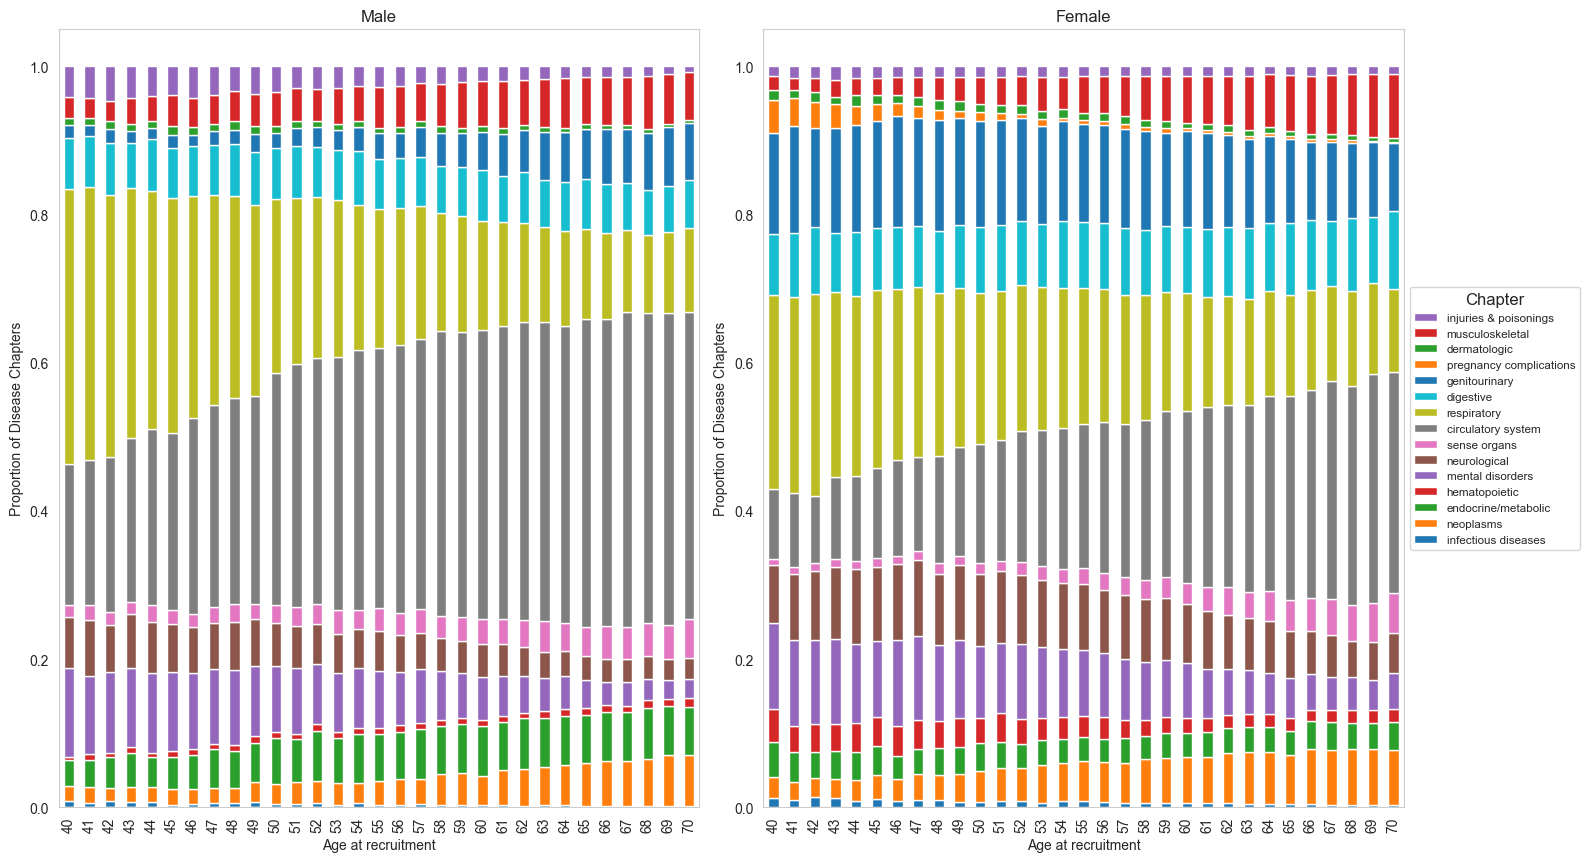

In [19]:
# 2.2.2 relative counts of the diseases
df_plot_2['total_diseases'] = df_plot_2[[f'chapter_{x}' for x in chapter_ranges]].sum(axis=1)
# Calculate the proportion of each chapter
for column in chapter_ranges:
    df_plot_2[f'chapter_{column}_prop'] = df_plot_2[f'chapter_{column}']/df_plot_2['total_diseases']

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [16,9]
# Create a subset of the dataframe with only the columns to be plotted
gender = 'Male'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}_prop' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)

# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title(gender)
ax1.set_xlabel('Age at recruitment')
ax1.set_ylabel('Proportion of Disease Chapters')
# remove the legend
ax1.get_legend().remove()


gender = 'Female'
df_subset = df_plot_2[df_plot_2['31'] == gender][['21022'] + [f'chapter_{i}_prop' for i in chapter_ranges]]
# Set '21022' as the index to be used as x-axis
df_subset.set_index('21022', inplace=True)

# Plot the stacked bar chart
df_subset.plot(kind='bar', stacked=True,  ax=ax2)
ax2.set_title(gender)
ax2.set_xlabel('Age at recruitment')
ax2.set_ylabel('Proportion of Disease Chapters')

handles, labels = ax2.get_legend_handles_labels()  # reverse the order of legend
labels = [phe_cate_dict[int(str(x).replace('chapter_','').replace('_prop',''))] for x in labels]
ax2.legend(reversed(handles), reversed(labels), title='Chapter', title_fontsize='large', fontsize='small', loc='center left', bbox_to_anchor=(1.0, 0.5))


for ax in [ax1, ax2]:
    ax.grid(False)
#fig.suptitle('Diseases chapter count by age and gender (Proportion)')
fig.tight_layout(rect=[0, 0.01, 1, 0.98])
# plt.show()

plt.savefig(params.current_path.parents[1]/f'plot/{level}/diseases_chapter_proportion_by_age_and_gender{"_weighted" if weight_control else ""}.pdf')


# disease occurrence

## within chapter

/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_1446/1556059432.py:6: FutureWarning: The provided callable <function mean at 0x7f9790f3fee0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_to_plot = df_to_plot.pivot_table(index=['31','21022'],values=[f'chapter_{x}' for x in chapter_ranges],aggfunc=np.mean)


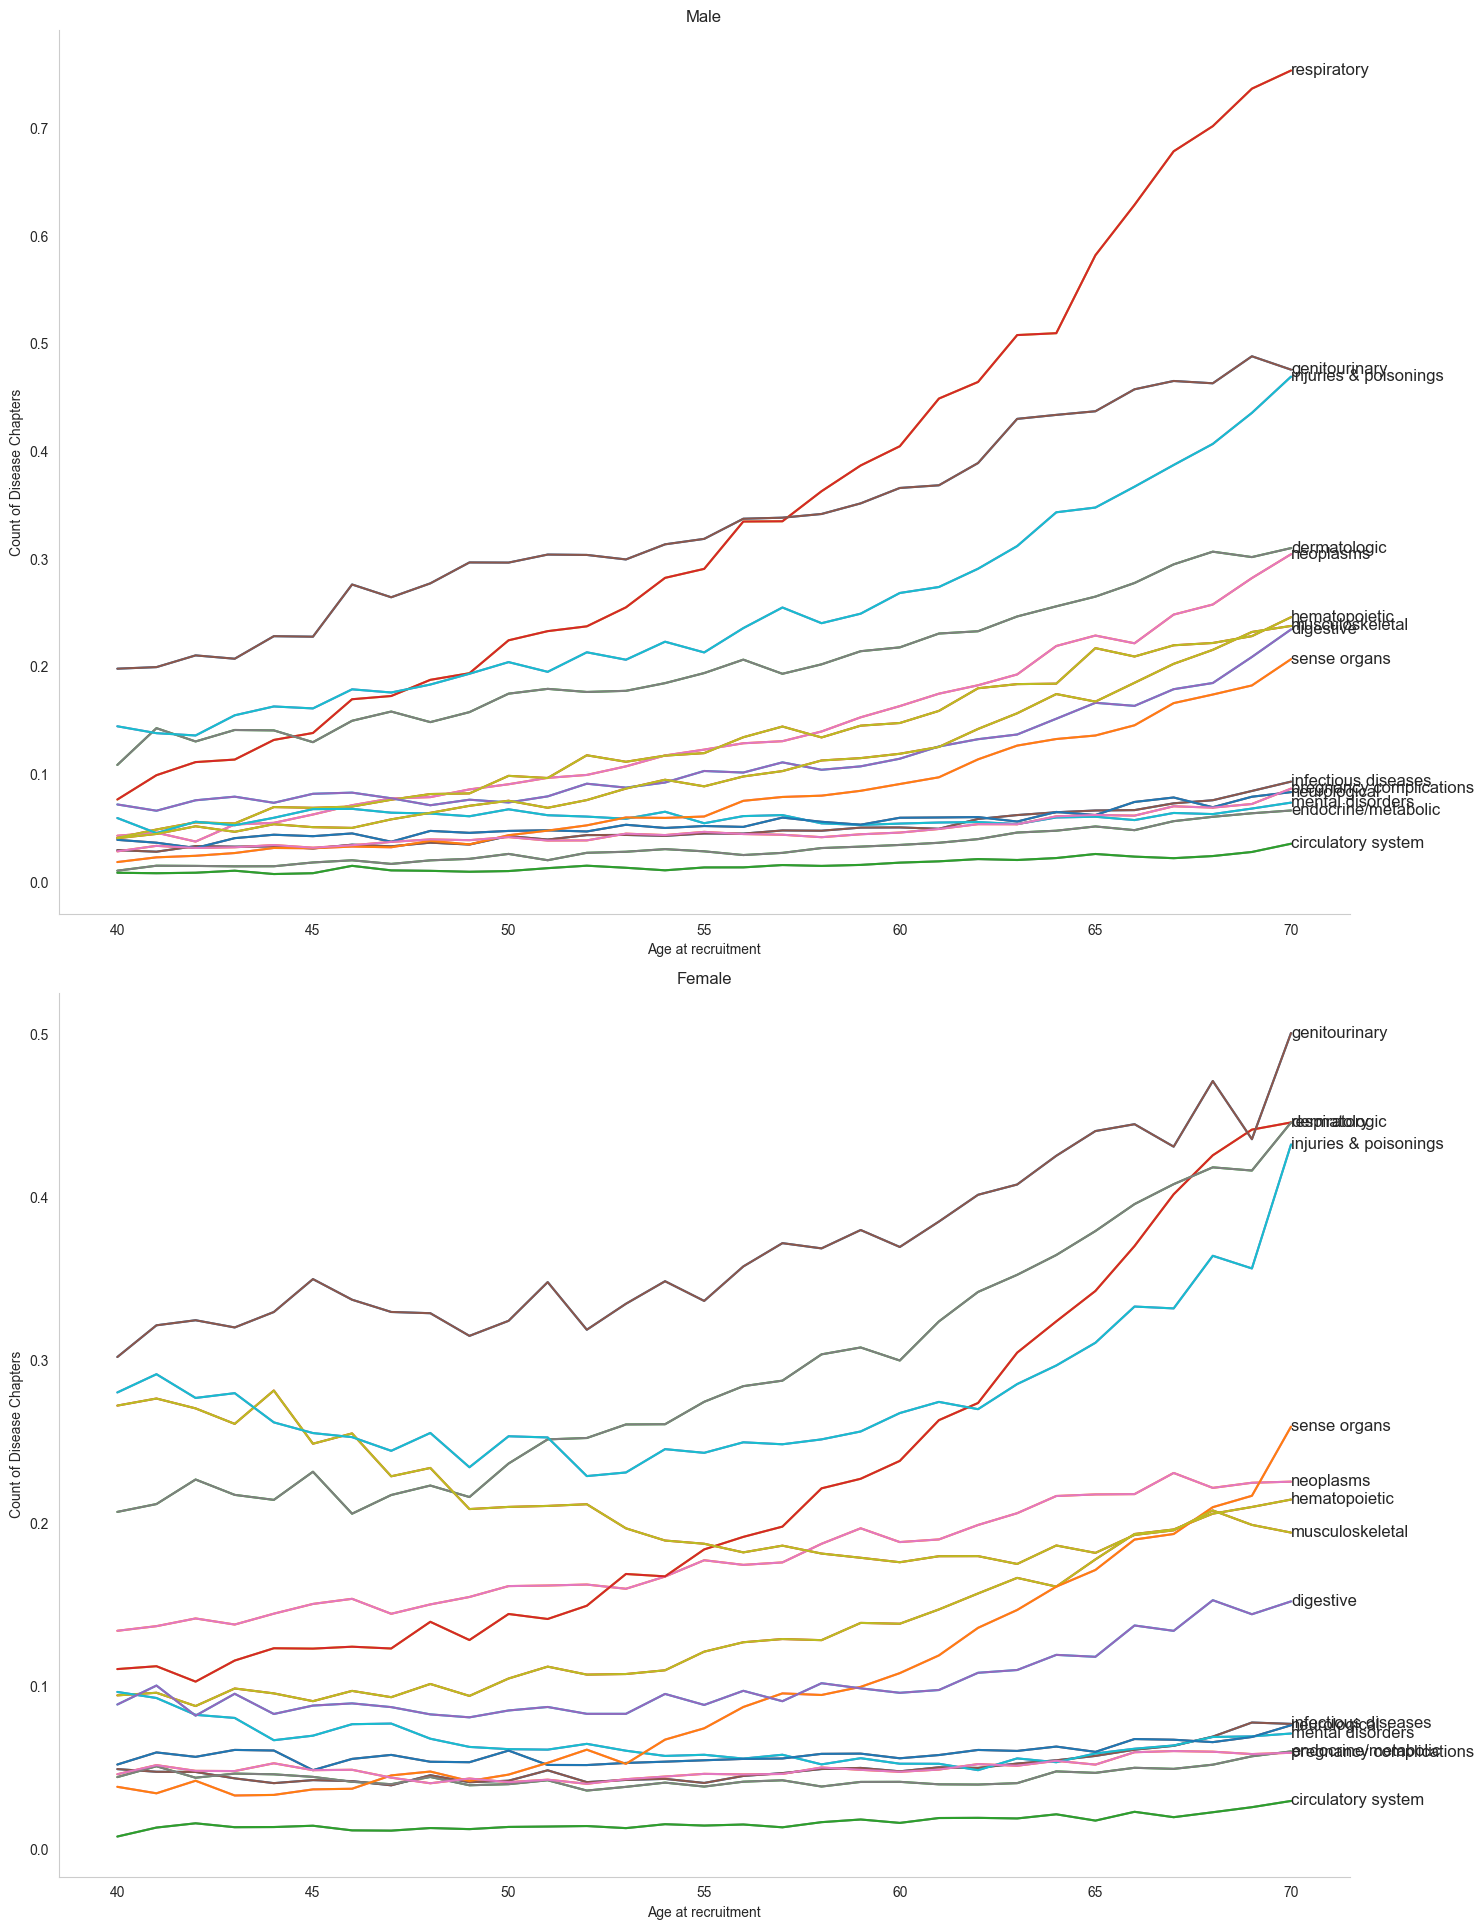

In [21]:


# self-repeating occurrence
# diseases related vars ['disease_count', 'chapter_1-22']

df_to_plot = df[['31', '21022']+[f'chapter_{x}' for x in chapter_ranges]]

df_to_plot = df_to_plot.pivot_table(index=['31','21022'],values=[f'chapter_{x}' for x in chapter_ranges],aggfunc=np.mean)
df_to_plot.reset_index(inplace=True)
df_to_plot.drop(df_to_plot.loc[(df_to_plot['21022'] < 40) | (df_to_plot['21022'] > 70)].index, inplace=True)

# set 31 as categorical variable
df_to_plot['31'] = df_to_plot['31'].astype('category')
df_to_plot['31'] = df_to_plot['31'].cat.rename_categories(['Female', 'Male'])

# remove diseases chapters that are bigger than 15

# within disease co-occurrence plot
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.rcParams["figure.figsize"] = [15, 20]

gender = 'Male'
df_subset = df_to_plot[df_to_plot['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
df_subset.set_index('21022', inplace=True)
df_subset.plot(kind='line', ax=ax1)
ax1.set_title(gender)
ax1.set_xlabel('Age at recruitment')
ax1.set_ylabel('Count of Disease Chapters')
for column in df_subset.columns:
    line = ax1.plot(df_subset.index, df_subset[column], label=column)
    last_x, last_y = df_subset.index[-1], df_subset[column].iloc[-1]
    ax1.text(last_x, last_y, phe_cate_dict[int(f'{column}'.replace('chapter_',''))], fontsize=12, verticalalignment='center')
ax1.legend().set_visible(False)

gender = 'Female'
df_subset = df_to_plot[df_to_plot['31'] == gender][['21022'] + [f'chapter_{i}' for i in chapter_ranges]]
df_subset.set_index('21022', inplace=True)
df_subset.plot(kind='line',  ax=ax2)
ax2.set_title(gender)
ax2.set_xlabel('Age at recruitment')
ax2.set_ylabel('Count of Disease Chapters')
for column in df_subset.columns:
    line = ax2.plot(df_subset.index, df_subset[column], label=column)
    last_x, last_y = df_subset.index[-1], df_subset[column].iloc[-1]
    ax2.text(last_x, last_y, phe_cate_dict[int(f'{column}'.replace('chapter_',''))], fontsize=12, verticalalignment='center')
ax2.legend().set_visible(False)

ax1.spines[['right', 'top' ]].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
# fig.suptitle(f'Diseases self-repeating rate by chapter {"(weighted)" if weight_control else ""}')
fig.tight_layout(rect=[0, 0.01, 1, 0.98])
# plt.show()
for ax in [ax1, ax2]:
    ax.grid(False)
# plt.savefig(params.current_path.parents[1]/f'plot/{level}/disease_co_occurrence_{record_column}_within_diseases_by_chapter_chronic.pdf')


## between chapter

/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_1446/503447272.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values))else x)


neoplasms
endocrine/metabolic
mental disorders
neurological
sense organs
circulatory system
respiratory
digestive
genitourinary
musculoskeletal
neoplasms circulatory system 20140
endocrine/metabolic circulatory system 38529
mental disorders circulatory system 28732
mental disorders respiratory 19181
neurological circulatory system 25986
neurological respiratory 16896
sense organs circulatory system 17469
circulatory system respiratory 61936
circulatory system digestive 37001
circulatory system genitourinary 35748
circulatory system musculoskeletal 30119
respiratory digestive 22575
respiratory genitourinary 22344
respiratory musculoskeletal 14932
digestive genitourinary 14568


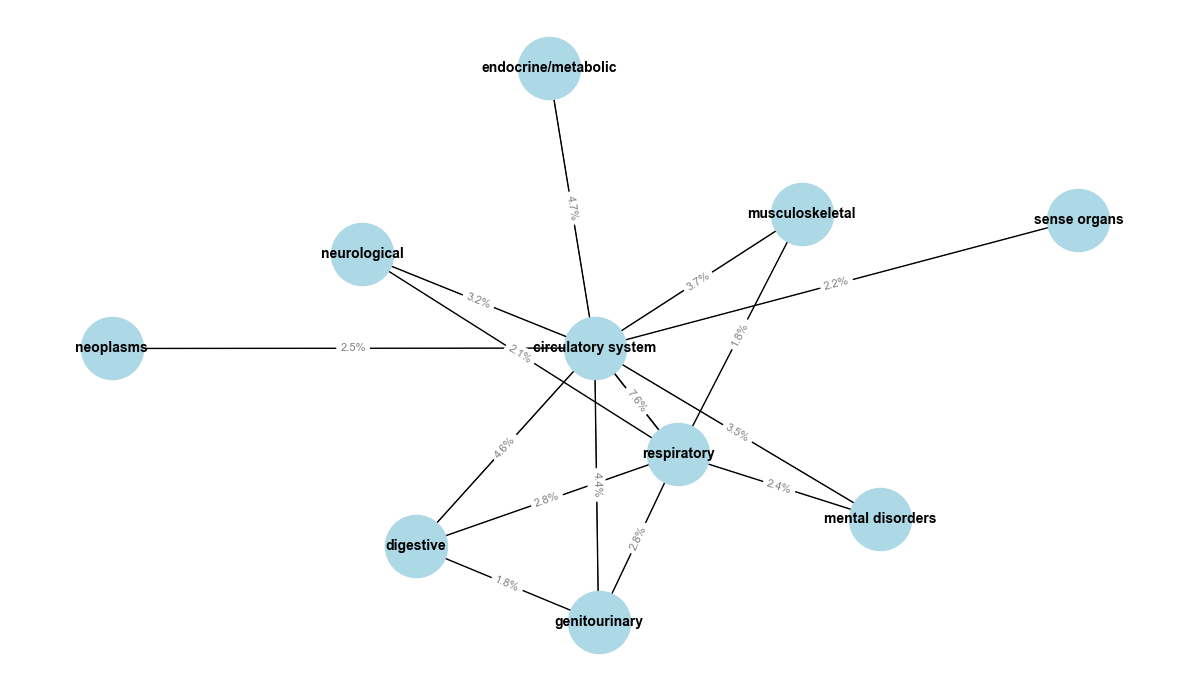

In [23]:

df_subset = df[[disease_count_column,disease_column, '31', '21022']].copy()
"""

# remove the chapters that we are less interested in
def remove_chapters_from_list(row,chapter_ranges):

    #remove the chapters that are not in the chapter_ranges

    if str(row) != 'None':
        chapters = row
        chapters = [x for x in chapters if x in chapter_ranges]
    else:
        chapters = None
    return chapters
df_subset[disease_column] = df_subset[disease_column].apply(lambda x: remove_chapters_from_list(x, chapter_ranges))

"""
# update the diesease count
if weight_control:
    df_subset[f'disease_count'] = [len(x)*weight if str(x) not in params.nan_str  else 0 for x,weight in zip(df[disease_column],df['weight'])]
else:
    df_subset[f'disease_count'] = [len(x) if str(x) not in params.nan_str else 0 for x in df[disease_column]]


# Sample data: list of transactions
dataset = [x for x in df_subset[disease_column].tolist() if str(x)!='None']

transaction_frequencies = [Counter(transaction) for transaction in dataset]

# Get all unique items
all_items = sorted(set(item for transaction in dataset for item in transaction))

# Create a frequency matrix where rows are transactions and columns are items
frequency_matrix = pd.DataFrame([{item: count[item] for item in all_items} for count in transaction_frequencies],
                                columns=all_items).fillna(0)


co_occurrence_matrix = np.dot(frequency_matrix.T, frequency_matrix)

# Set diagonal to zero to remove self-loops (optional, if you don't want self-links)
np.fill_diagonal(co_occurrence_matrix, 0)

# Convert to DataFrame for easier interpretation
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=frequency_matrix.columns, columns=frequency_matrix.columns)

threshold = 0.01
# replace the value below the threshold with 0
co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values))else x)
co_occurrence_df.columns = [phe_cate_dict[int(x)] for x in co_occurrence_df.columns]

# Step 2: Create a network graph using NetworkX
G = nx.Graph()

# Add nodes (items)
for item in co_occurrence_df.columns:
    if sum(co_occurrence_df[item]) > 0:
        print(item)
        G.add_node(item)

edge_set = set()
# Add edges (co-occurrences) if the co-occurrence value is greater than 0
for i, item1 in enumerate(co_occurrence_df.columns):
    for j, item2 in enumerate(co_occurrence_df.columns):
        if co_occurrence_df.iloc[i, j] > 0:
            edge_set.add((item1, item2))
            if (item2, item1) not in edge_set:
                print(item1, item2, co_occurrence_df.iloc[i, j])
                G.add_edge(item1, item2, weight=round(co_occurrence_df.iloc[i, j]/sum(sum(co_occurrence_df.values)),3))

# remove edges with weight less than 0.02
G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0.01])

# Step 3: Visualize the network
fig, ax = plt.subplots(figsize=(12,7))
pos = nx.spring_layout(G,seed=1234)  # Layout for visualization
#pos["circulatory system"][1] = pos["circulatory system"][1]-0.5
#pos["circulatory system"][0] = pos["circulatory system"][0]-0.2

pos["respiratory"][0] = pos["respiratory"][0]+0.1
# pos["neoplasms"][0] = pos["neoplasms"][0]+0.5

#pos["digestive"][0] = pos["digestive"][0]+0.3
#pos["digestive"][1] = pos["digestive"][1]+0.3


nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', ax=ax)
edge_labels = nx.get_edge_attributes(G, 'weight')

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']*12 for u, v, d in edges],ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels={x: f'{round(y * 100, 2)}%' for x,y in edge_labels.items()}, font_color='grey', font_size=8,ax=ax)
# remove edges with weight less than 0.02
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

# fig.suptitle('Disease Chapter Co-occurrence Network View')
fig.tight_layout()

# plt.show()

# plt.savefig(params.current_path.parents[1]/f'plot/{level}/disease_co_occurrence_between_diseases_by_{level}_{record_column}_{"_weighted" if weight_control else ""}.pdf')
plt.savefig(params.current_path.parents[1]/f'plot/{level}/disease_co_occurrence_between_diseases_by_{level}_{"_weighted" if weight_control else ""}.pdf')


## disease level co-occurrence by gender 

In [25]:
df_phe_db = pd.read_csv(f'{str(params.ICD_path ).replace("src/data_preprocess/","")}/phecode_definitions1.2.csv')
if disease_columns[0] not in df.columns.tolist():
    # df_disease[disease_columns[0]] = [ast.literal_eval(x) if str(x) not in params.nan_str else None for x in df_disease[disease_columns[0]]]
    df = df.merge(df_disease[['eid', disease_columns[0]]], how='left', left_on='eid', right_on='eid')
df_subset = df[[disease_count_column,disease_columns[0], '31', '21022']].copy()

gender_dict = {0:'Female',1:'Male'}

/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_1446/3893042486.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Pastel1', lut=df_phe_db['category'].nunique())  # Use the number of unique chapters
/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_1446/3893042486.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values)) else x)
/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_1446/3893042486.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values)) else x)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/valler/Python/OX_Thesis/Chapter_2_Disease_Clustering/src/data_preprocess/plot/fo+cancer/chronic_cate/diseases_network_view_by_gender.pdf'

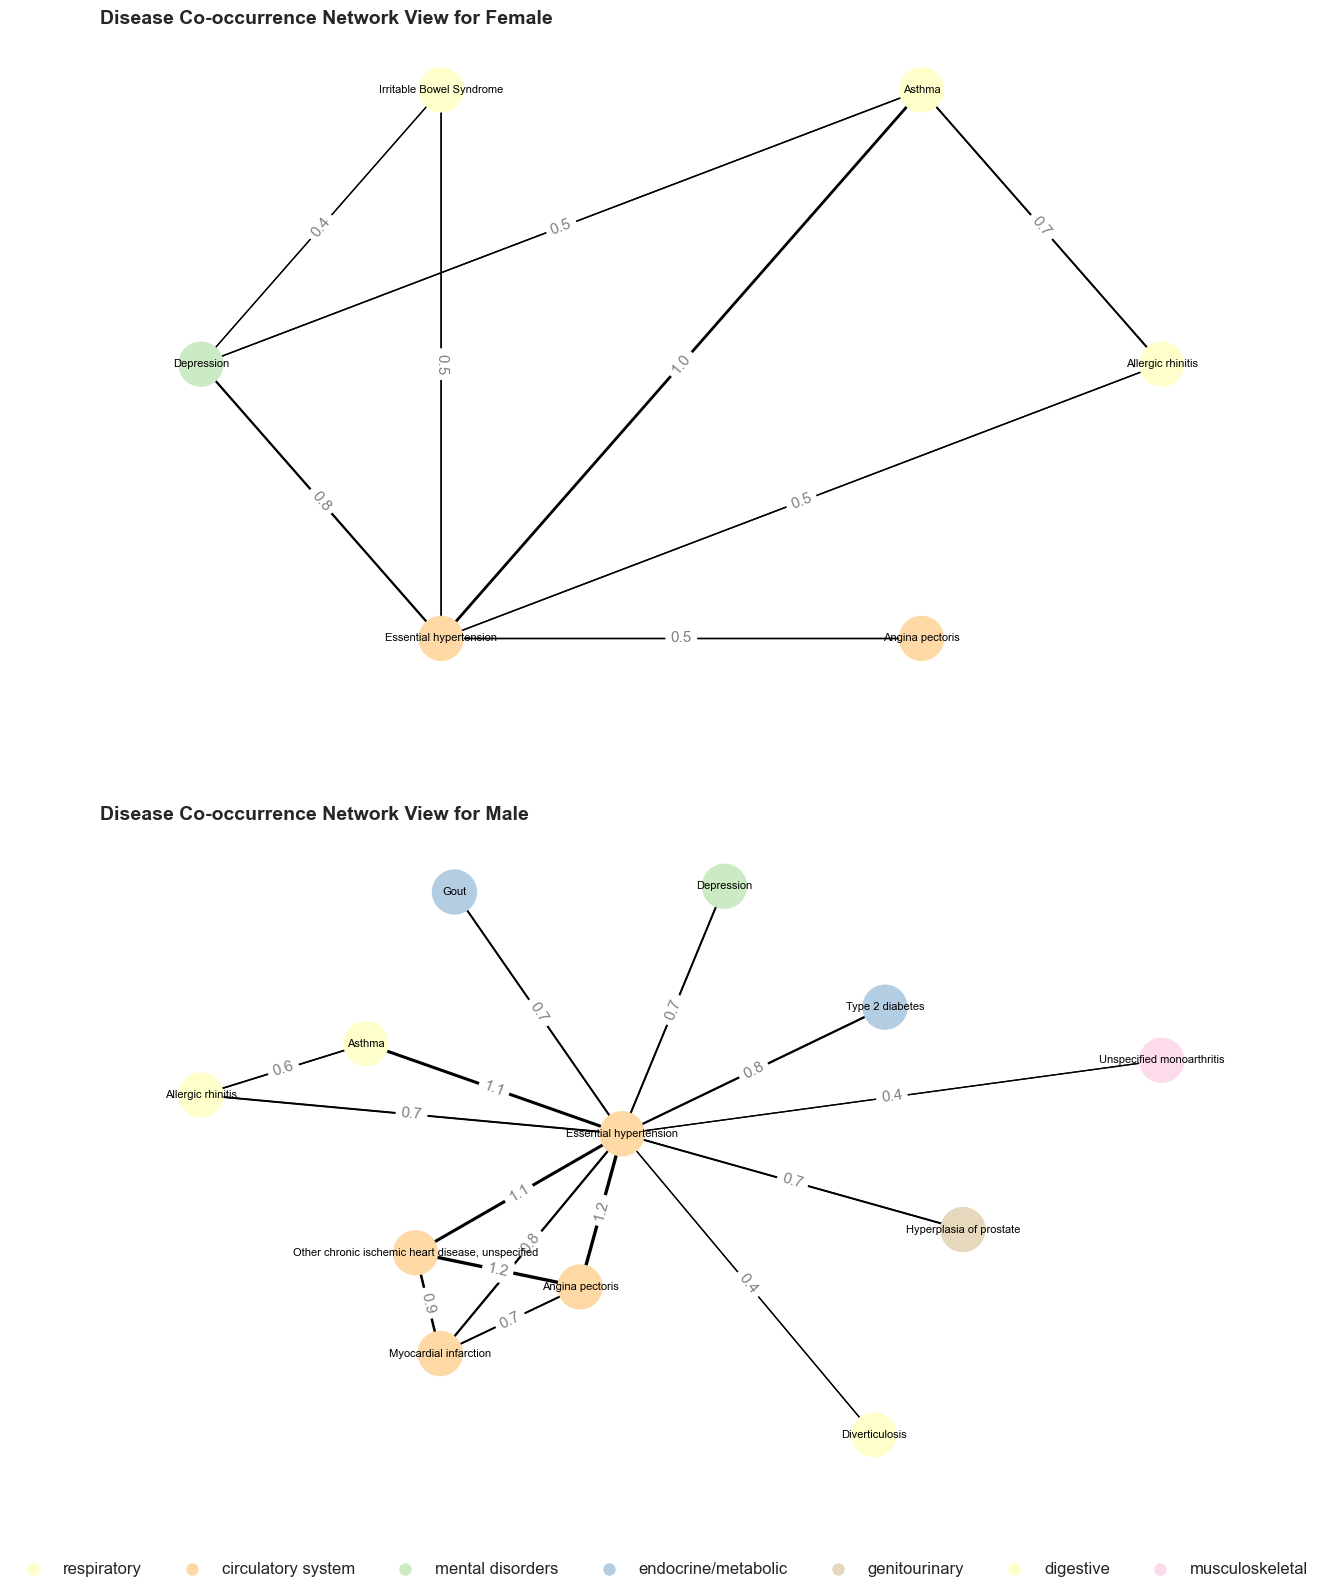

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.cm import get_cmap


cmap = get_cmap('Pastel1', lut=df_phe_db['category'].nunique())  # Use the number of unique chapters

# Assign colors to each chapter dynamically using the colormap
unique_chapters = df_phe_db['category'].unique().tolist()
chapter_colors = {chapter: cmap(i) for i, chapter in enumerate(unique_chapters)}


# Function to assign colors based on chapter values
def get_node_color(disease):
    chapter = disease_chapter_dict.get(disease, 'Unknown')
    return chapter_colors.get(chapter, 'grey')  # Default to grey if the chapter is unknown
valid_chapters=set()

fig, axs = plt.subplots(2, 1, figsize=(15, 20))

ax0 = axs[0]
ax1 = axs[1]

for gender in [1, 0]:
    dataset = [x for x in df_subset.loc[df_subset['31'] == gender, disease_columns[0]].tolist() if str(x) != 'None']

    transaction_frequencies = [Counter(transaction) for transaction in dataset]

    # Get all unique items
    all_items = sorted(set(item for transaction in dataset for item in transaction))

    # Create a frequency matrix
    frequency_matrix = pd.DataFrame([{item: count[item] for item in all_items} for count in transaction_frequencies],
                                    columns=all_items).fillna(0)

    co_occurrence_matrix = np.dot(frequency_matrix.T, frequency_matrix)

    # Set diagonal to zero
    np.fill_diagonal(co_occurrence_matrix, 0)

    # Convert to DataFrame
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=frequency_matrix.columns, columns=frequency_matrix.columns)

    threshold = 0.004
    co_occurrence_df = co_occurrence_df.applymap(lambda x: 0 if x<threshold*sum(sum(co_occurrence_df.values)) else x)

    # Update disease labels
    # disease chapter colors


    co_occurrence_df.columns = [df_phe_db.loc[df_phe_db['phecode'] == float(x), 'phenotype'].values[0] for x in co_occurrence_df.columns]

    disease_chapter_dict = {x: df_phe_db.loc[df_phe_db['phenotype'] == x, 'category'].values[0] for x in co_occurrence_df.columns}

    # Create a network graph using NetworkX
    G = nx.Graph()

    # Add nodes with color mapped by chapter values
    for item in co_occurrence_df.columns:
        if co_occurrence_df[item].sum() > 0:
            G.add_node(item, color=get_node_color(item))
            valid_chapters.add(disease_chapter_dict[item])
    # Add edges
    for i, item1 in enumerate(co_occurrence_df.columns):
        for j, item2 in enumerate(co_occurrence_df.columns):
            if co_occurrence_df.iloc[i, j] > 0:
                G.add_edge(item1, item2, weight=round(co_occurrence_df.iloc[i, j] / co_occurrence_matrix.sum().sum() * 100, 1))

    # Node color based on disease chapters
    node_colors = [G.nodes[n]['color'] for n in G.nodes]

    if gender == 0:
        pos = nx.shell_layout(G)
        ax = ax0
        #pos['Essential hypertension'][1] = pos['Essential hypertension'][1] -0.1
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=8, ax=ax)
    else:
        pos = nx.spring_layout(G, seed=1238174)
        ax = ax1

        labels = {x:y if not x.startswith('Unstable angina') else 'Unstable angina' for x,y in zip(G.nodes,G.nodes)}

        #pos['Myocardial infarction'][0] = pos['Myocardial infarction'][0] -0.4
        #pos['Myocardial infarction'][1] = pos['Myocardial infarction'][1] -0.5
        #pos['Hypercholesterolemia'][1] = pos['Hypercholesterolemia'][1] + 0.8
        #pos['Angina pectoris'][1] = pos['Angina pectoris'][1] - 0.2
        #pos['Other chronic ischemic heart disease, unspecified'][1] = pos['Other chronic ischemic heart disease, unspecified'][1] - 0.5
        #pos['Other chronic ischemic heart disease, unspecified'][0] = pos['Other chronic ischemic heart disease, unspecified'][0] - 0.2
        #pos['Coronary atherosclerosis'][1] = pos['Coronary atherosclerosis'][1] + 0.4
        #pos['Essential hypertension'][0] = pos['Essential hypertension'][0] -0.2
        #pos['Essential hypertension'][1] = pos['Essential hypertension'][1] -0.1

        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=8, ax=ax,labels=labels)

    edge_labels = nx.get_edge_attributes(G, 'weight')
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight'] * 2 for u, v, d in edges], ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='grey', font_size=11, ax=ax)
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.set_title(f'Disease Co-occurrence Network View for {"Male" if gender == 1 else "Female"}', fontsize=14, fontweight='bold', loc='left')

#  Create a legend at the bottom for only valid chapters
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=chapter_colors[chapter], markersize=10, label=chapter)
                 for chapter in valid_chapters]

fig.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=len(valid_chapters), fontsize=12, frameon=False)

plt.subplots_adjust(bottom=0.15)
plt.savefig(params.current_path.parents[1]/f'plot/{level}/diseases_network_view_by_gender.pdf')

